In [1]:
from spectra_database import *
from plasma_char import *
from read_files import *

import numpy as np
from matplotlib.pyplot import *

import h5py

# 1. Getting Started with Plasma emission spectroscopy

As referred in the protocol, LIBS make use of concepts related with emission spectroscopy. In particular, we will seek to analyse the obtained spectrum by searching for characteristic element and ionic emission lines. The parameters for these specific emission lines can be found in many resources online ( e.g. https://physics.nist.gov/PhysRefData/ASD/LIBS/libs-form.html ). For this activity we previously gathered some data from the NIST database and stored in a local offline library, which you can access with the function get_spectra(element). The online version of the function, get_spectra_online(element, density = 1e17, temperature = 1) allows to further control the plasma density and temperature but requires network connection to obtain it directly from the NIST online database. 

For both functions the output dataset has the structure [wavelengths,atomic lines, ionic lines +1, ionic lines +2] .

<IPython.core.display.Javascript object>


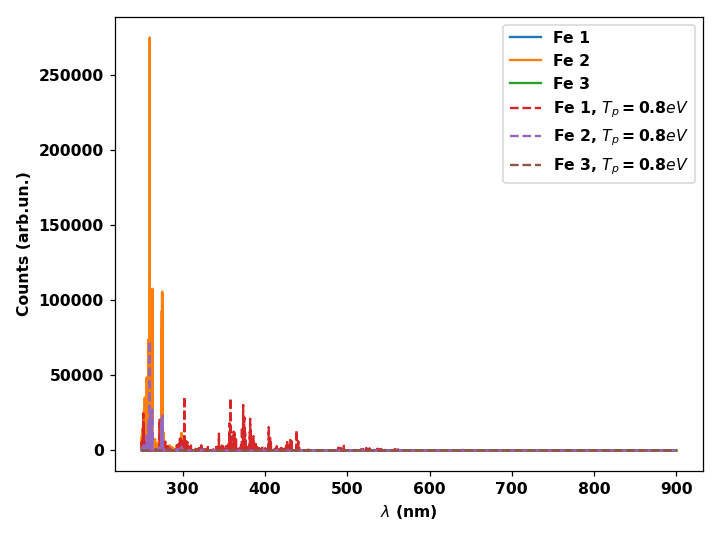

In [48]:
%matplotlib widget
element = 'Fe'


spectrum1 = get_spectra(element)
spectrum2 = get_spectra_online(element, density = 1.2e17, temperature=0.8)

subplots()
wavelengths = spectrum1[:,0]
plot(wavelengths, spectrum1[:,1],label=element+' 1')
plot(wavelengths, spectrum1[:,2],label=element+' 2')
plot(wavelengths, spectrum1[:,3],label=element+' 3')

wavelengths = spectrum2[:,0]
plot(wavelengths, spectrum2[:,1],ls='--',label=element+' 1, $T_p=0.8eV$')
plot(wavelengths, spectrum2[:,2],ls='--',label=element+' 2, $T_p=0.8eV$')
plot(wavelengths, spectrum2[:,3],ls='--',label=element+' 3, $T_p=0.8eV$')

legend()
xlabel('$\lambda$ (nm)')
ylabel('Counts (arb.un.)')
tight_layout()


You are now in conditions of comparing the theoretical emission spectrum for an element with an experimental spectrum for a sample. For reading the data in a specific folder you just need to call the function 
1. read_libs_data(folder): returns an array of wavelenghts for each spectrometer (7 in total x 2048 pixels) and an array of shots for each spectrometer with shape (nspectrometers, nshots, npixels)

In [49]:
wavelength, signals, positions = read_libs_data(r'Fe\\spot1\\')
signals.shape

(1, 7, 2048)

Now let's see if the sample has Iron:

<IPython.core.display.Javascript object>


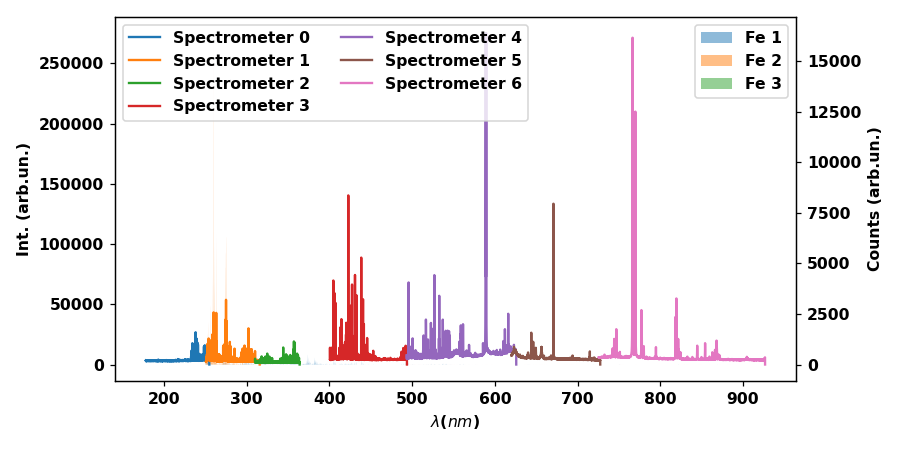

In [61]:
element = 'Fe'



spectrum1 = get_spectra(element)
ref_wavelengths = spectrum1[:,0]

subplots(figsize=[8,4])
#Plot digital Spectra
fill_between(ref_wavelengths, spectrum1[:,1],label=element+' 1',alpha=0.5)
fill_between(ref_wavelengths, spectrum1[:,2],label=element+' 2',alpha=0.5)
fill_between(ref_wavelengths, spectrum1[:,3],label=element+' 3',alpha=0.5)
legend(loc=0)

xlabel(r'$\lambda (nm)$')
ylabel(r'Int. (arb.un.)')

#Plot a single shot
ax = twinx()
shot_n = 0
for i in range(0,len(wavelength)):
    plot(wavelength[i], signals[shot_n][i],label='Spectrometer '+str(i))
legend(loc=2,ncol=2)

ylabel(r'Counts (arb.un.)')
tight_layout()
#plt.xlim(400,450)

# 2. Measure peak areas, variations from shot to shot and parameters

A typical physics experiment involves collecting some data and analysing it (if possible during the experiment). After the brief qualitative analysis performed above, you will see now how to extract some features from the LIBS signal by computing the intensity of specific emission lines, which are important to characterize how plasma varies with the system parameters (Q-switch delay, spectrometer delay, integration time, etc.). For this task you can either select directly the index corresponding to the wavelength you want, or compute the total peak are (when do you think you should use one or another?). For this you can use two functions that are already defined:
1. get_peak_intensity(wl,signal,l0, Plot=True): returns the intensity of the index closest to l0, plot a graph depicting the result if Plot == True;
2. get_peak_area_intensity(wl, signal, l0, Plot=True): returns the peak area at halfwidth for the peak closest to l0 in a radius of 0.2 nm, and plot a graph depicting the result if Plot == True;

<IPython.core.display.Javascript object>


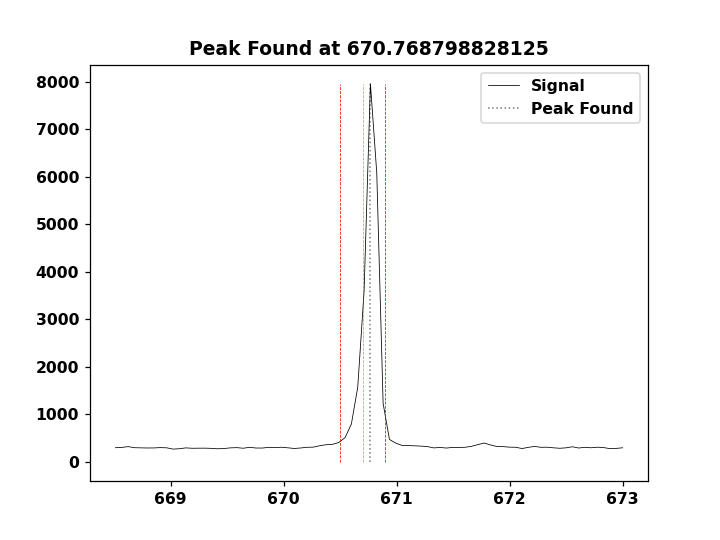

<IPython.core.display.Javascript object>


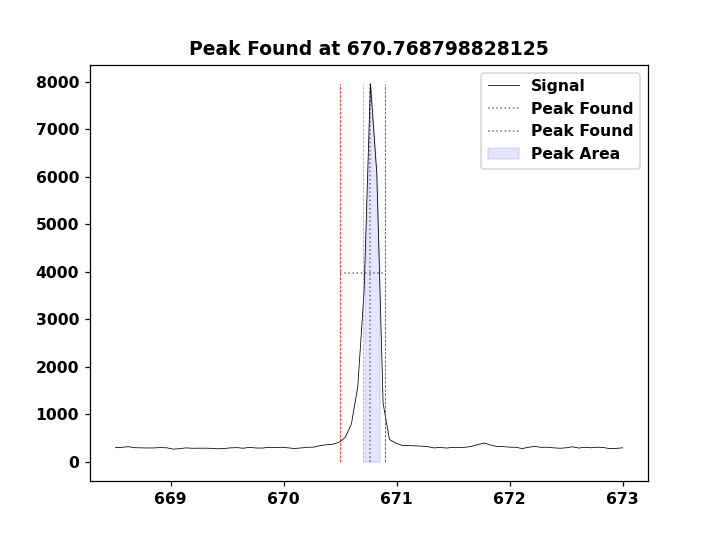

intensity at max =  7957.25
peak area intensity at max =  820.6064621494874


In [62]:
#Do not forget to choose the right spectrometer for the target range
n_spec = 5
line_0 = 670.7
intensity = get_peak_intensity(wavelength[n_spec], signals[shot_n][n_spec], l0=line_0, Plot=True)
peak_area = get_peak_area_intensity(wavelength[n_spec], signals[shot_n][n_spec], l0=line_0, Plot=True)

print('intensity at max = ', intensity)
print('peak area intensity at max = ', peak_area)

# 3. Measuring plasma properties

As described in the protocol for this experiment, we will characterize the plasma using concepts related with the Stark broadening of the Hydrogen $\alpha$ line and the Saha-Boltzmann plot for computing the electron density and plasma temperature, respectively. For this you may use two functions that are already implemented:

1. get_plasma_density(wl, signal, Plot=True): given the wavelengths and associated signal for the correct channel of the spectrometer containing the $\alpha$ line retrieves and plots the fit if Plot=True;

1. get_plasma_temperature(lines, ion_energies, wl, signal): given a list of parameters for the lines for an element as described in the example and the ion energies plus the wavelengths and associated signal (full list), retrievves the temperature and the xs and ys values of the saha-boltzmann plot.

C:\Users\nunoa\LAF1\LIBS\LIBS2022\plasma_char.py:14: RuntimeWarning: overflow encountered in multiply
  return A*special.voigt_profile(x-x0,sigma, gamma)


<IPython.core.display.Javascript object>


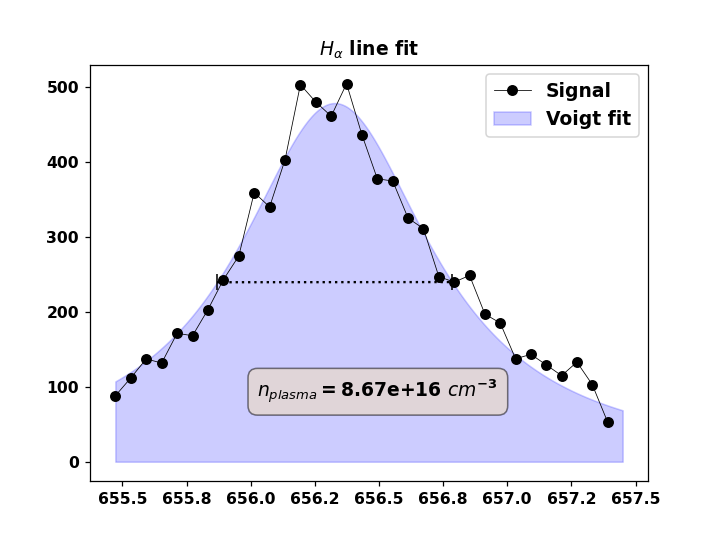

<IPython.core.display.Javascript object>


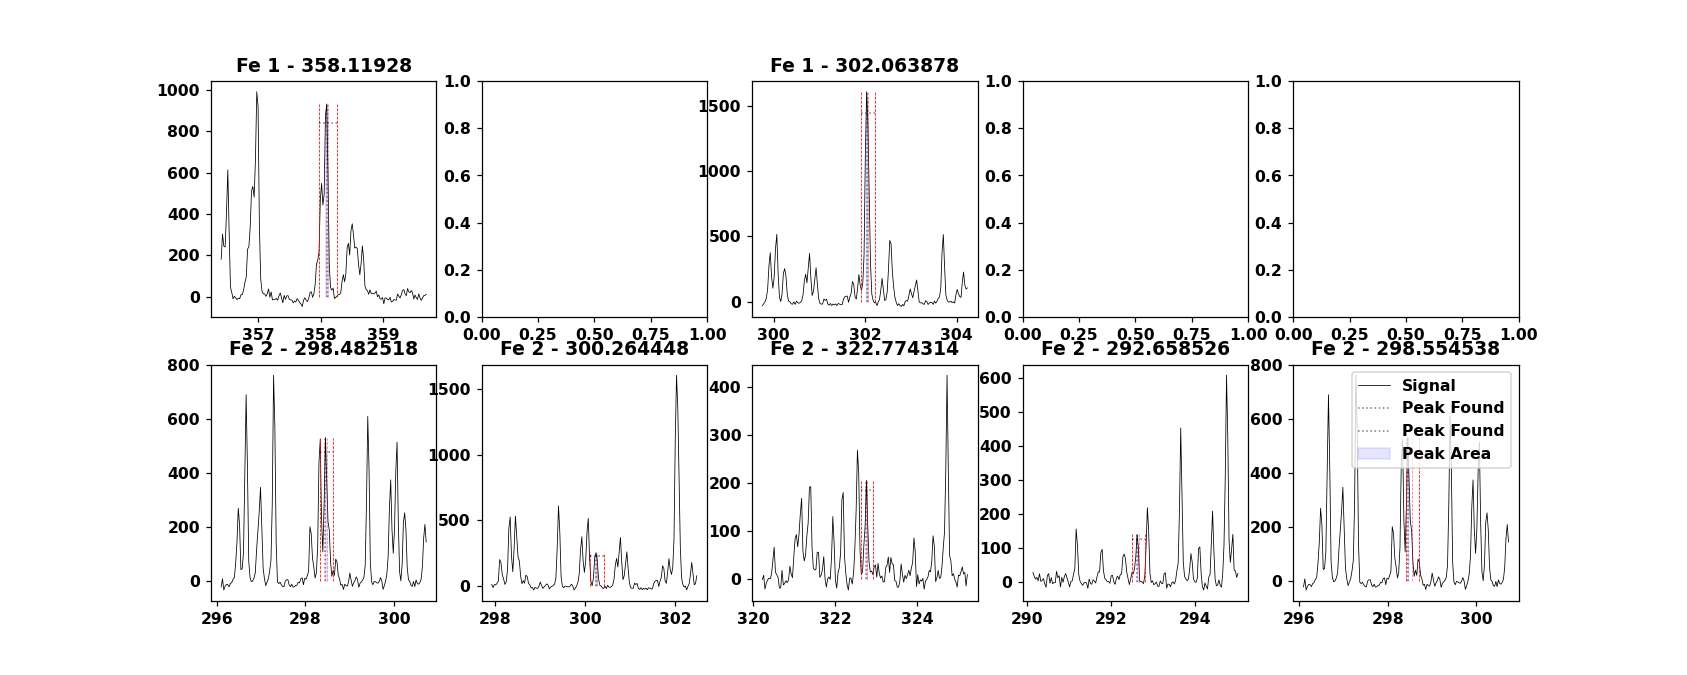

 *** Warning - line 373.486354 for Fe 1 not found within the given range
 *** Warning - line 374.948483 for Fe 1 not found within the given range
 *** Warning - line 382.04249100000004 for Fe 1 not found within the given range


<IPython.core.display.Javascript object>


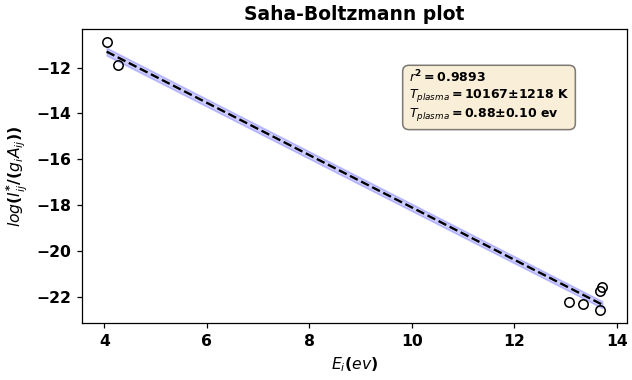

In [63]:
#A list with most relevant lines for Fe - you can find scrap the NIST database for this and for other elements
#https://physics.nist.gov/PhysRefData/ASD/lines_form.html

#line properties = [wavelength, g, A, ion state, label, e_upper]

lines_atomic = [[358.11928, 13.0, 102000000.0, 1.0, 'Fe', 4.32010008],
              [373.486354, 11.0, 90100000.0, 1.0, 'Fe', 4.17769679],
              [302.063878, 9.0, 75900000.0, 1.0, 'Fe', 4.10337372],
              [374.948483, 9.0, 76300000.0, 1.0, 'Fe', 4.22036211],
              [382.04249100000004, 9.0, 66700000.0, 1.0, 'Fe', 4.10337372]]

lines_ion_1 = [[298.482518, 6.0, 43000000.0, 2.0, 'Fe', 5.82322475],
              [300.264448, 6.0, 17900000.0, 2.0, 'Fe', 5.82322475],
              [322.774314, 8.0, 8900000.0, 2.0, 'Fe', 5.5107139],
              [292.658526, 10.0, 5100000.0, 2.0, 'Fe', 5.22157443],
              [298.554538, 4.0, 23900000.0, 2.0, 'Fe', 5.87558748]]


data_lines1 = [lines_atomic, lines_ion_1]
ion_energies1 = np.array([7.90255, 16.187531])

#####################3

density = get_plasma_density(wavelength[n_spec], signals[shot_n][n_spec])
temperature, ys,xs = get_plasma_temperature(data_lines1, ion_energies1,wavelength, signals[shot_n])

